In [1]:
### RUN EVERY TIME: COMTRADE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
import gc
import os
import datetime
import time

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [12]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2022-12-31'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Checked EBOPS service IDs list (df_serv_to_gics['GICS Group Code']):
list_services = ['206', '210', '214', '218', '219', '223', '227', '231', '232', '237', '240', '246', '247', '250', '251', '254', '255', '256', '257', '258', '263',
                 '264', '269', '272', '273', '288', '289', '292', '293', '294', '310', '391', '431', '500', '888', '891', '892', '894', '950']
### Augmented bilateral export:
str_path_export_bilateral = 'Data_Files/Source_Files/comtrade_export_bilateral.h5'
### Export key:
str_key_unc_export = 'export_augmented'
### Augmented bilateral import:
str_path_import_bilateral = 'Data_Files/Source_Files/comtrade_import_bilateral.h5'
### Import key:
str_key_unc_import = 'import_augmented'
### Augmented bilateral import:
str_path_gdp = 'Data_Files/Source_Files/gdp_dataset.h5'
### Factor file:
str_path_herfindahl_full_exp = 'Data_Files/Source_Files/comtrade_herfindahl_full_exp.h5'
str_path_herfindahl_comm_exp = 'Data_Files/Source_Files/comtrade_herfindahl_comm_exp.h5'
str_path_herfindahl_partner_exp = 'Data_Files/Source_Files/comtrade_herfindahl_partner_exp.h5'
str_path_herfindahl_for_comm_exp = 'Data_Files/Source_Files/comtrade_herfindahl_for_comm_exp.h5'
str_path_herfindahl_partner_imp = 'Data_Files/Source_Files/comtrade_herfindahl_partner_imp.h5'
str_key_comtrade_factor = 'comtrade_factor'
str_path_factor_xlsx = 'Data_Files/Source_Files/comtrade_factor.xlsx'
str_path_factor_csv = 'Data_Files/Source_Files/comtrade_factor.csv'
### IOnteraction variable file:
str_path_interact_var = 'Data_Files/Source_Files/comtrade_interact_exp.h5'
str_key_interact_var = 'interact_var'

In [5]:
### DEFINING WEIGHTED AVERAGE CALCULATOR

def weighted_average(ser_data, ser_weight = None, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if ser_weight is None:
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [6]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [7]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [8]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
ser_ison_membership.index.names = ['Date', 'Reporter']
### ISON Members:
list_ison_countries = sorted(ser_ison_membership.index.get_level_values('Reporter').unique())
### ISON status for the last available date:
ser_ison_status = ser_ison_membership.loc[ser_ison_membership.index[-1][0]]

In [ ]:
### BILATERAL EXPORT DATA LOADING TO PERFORM FACTOR CALCULATION

gc.collect()
list_export_chunks = []
for num_iter_number, ser_iter_chunk in enumerate(pd.read_hdf(str_path_export_bilateral, key = str_key_unc_export, chunksize = 1000000)):
    gc.collect()
    print(num_iter_number, ': Extraction started')
    ser_iter_chunk = ser_iter_chunk[ser_iter_chunk > 0.0].astype('int32')
    df_iter_chunk = ser_iter_chunk.reset_index()
    df_iter_chunk = df_iter_chunk[(df_iter_chunk['Reporter'] != df_iter_chunk['Partner']) & \
                                  ((df_iter_chunk['Type'] == 'Goods') | df_iter_chunk['Commodity_ID'].isin(list_services)) & (df_iter_chunk['Reporter'] != 'World') & \
                                  (df_iter_chunk['Partner'] != 'World')]\
                               .drop('Type', axis = 1)    
    print(num_iter_number, ': Filtering performed')    
    ser_iter_chunk = df_iter_chunk.set_index(['Date', 'Reporter', 'Partner', 'Commodity_ID']).squeeze().sort_index()
    del df_iter_chunk
    gc.collect()
    list_export_chunks.append(ser_iter_chunk)
    print(num_iter_number, ': Chunk added to container')    
ser_bilateral_export = pd.concat(list_export_chunks, axis = 0, sort = False).sort_index()
ser_bilateral_export.name = 'Export'
del list_export_chunks
gc.collect()

In [10]:
### SUM OF FLOWS PREPARATION

gc.collect()
ser_country_comm_flow = ser_bilateral_export.groupby(['Date', 'Reporter', 'Commodity_ID']).sum()
gc.collect()
ser_country_partner_flow = ser_bilateral_export.groupby(['Date', 'Reporter', 'Partner']).sum()

In [ ]:
### CALCULATION OF FULL HERFINDAHL INDEX

gc.collect()
### Defining Herfindahl index calculation:
def get_herfindahl(ser_group):
    if (ser_group.count() > 0):
        ser_norm = ser_group / ser_group.sum()
        flo_herfindahl = 1 / ((ser_norm ** 2).sum() ** (1 / 2))
    else:
        flo_herfindahl = np.NaN
    return flo_herfindahl

ser_herfindahl_full = ser_bilateral_export.loc[:, ser_ison_status.index].groupby(['Date', 'Reporter']).apply(get_herfindahl)

In [31]:
### FULL HERFINDAHL FACTOR RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(df_group):
    df_result = df_group.droplevel(['Reporter']).reindex(pd.date_range(df_group.index[0][0], str_date_end, freq = 'BY'))
    df_result = df_result.resample('BM').ffill()
    return df_result
ser_herfindahl_monthly = ser_herfindahl_full.groupby('Reporter').apply(reindex_monthly).swaplevel()
ser_herfindahl_monthly.index.names = ['Date', 'Reporter']
ser_herfindahl_monthly.name = 'Herfindahl_Full'

In [35]:
### FACTOR SAVING

ser_herfindahl_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
ser_herfindahl_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
ser_herfindahl_monthly.to_hdf(str_path_herfindahl_full_exp, str_key_comtrade_factor)

In [13]:
### CALCULATION OF BY COMMODITY HERFINDAHL INDEX

gc.collect()
### Defining Herfindahl index calculation:
def get_herfindahl(ser_group):
    if (ser_group.count() > 0):
        ser_norm = ser_group / ser_group.sum()
        flo_herfindahl = 1 / ((ser_norm ** 2).sum() ** (1 / 2))
    else:
        flo_herfindahl = np.NaN
    return flo_herfindahl

ser_herfindahl_comm = ser_country_comm_flow.loc[:, ser_ison_status.index].groupby(['Date', 'Reporter']).apply(get_herfindahl)
ser_herfindahl_comm.replace({np.inf: np.NaN}, inplace = True)
ser_herfindahl_comm.name = 'Herfindahl_Commodity'

In [16]:
### TEST: LOADING COMMODITIES TO INDUSTRIES MAP

### Commodity to industry connection:
str_path_industry_map_xlsx = 'Data_Files/Source_Files/goods_to_industries_hs.xlsx'
str_page_services = 'EBOPS'
str_page_goods = 'AG2'

df_goods_to_ind = pd.read_excel(engine = 'openpyxl', io = str_path_industry_map_xlsx, sheet_name = str_page_goods, header = 0, dtype = 'object',
                                na_values = list_na_excel_values, keep_default_na = False).set_index('Commodity ID')
df_goods_to_ind.index.names = ['Commodity_ID']
ser_goods_to_ind = df_goods_to_ind.dropna()['GICS Industry Group'].squeeze()
ser_goods_to_ind.name = 'Industry_Group'
df_services_to_ind = pd.read_excel(engine = 'openpyxl', io = str_path_industry_map_xlsx, sheet_name = str_page_services, header = 0, dtype = 'object',
                                na_values = list_na_excel_values, keep_default_na = False).set_index('Service ID')
df_services_to_ind.index.names = ['Commodity_ID']
ser_comm_description = pd.concat([df_goods_to_ind['AG2'], df_services_to_ind.loc[list_services, 'Service Description']], axis = 0)
ser_comm_description.name = 'Description'

In [32]:
### TEST: VISUALIZATION

str_test_date = '2020-12-31'
str_test_country = 'QA'

ser_test_flow = ser_country_comm_flow.loc[str_test_date, str_test_country, :]
print(get_herfindahl(ser_test_flow))

ser_test_weights = (ser_test_flow / ser_test_flow.sum()).nlargest(10)
#ser_test_weights = ser_test_weights.to_frame().join(ser_comm_description.str.replace(';', '').str.split(' ').str[ : 7].str.join(' '))\
#                                   .set_index('Description', append = True).droplevel('Commodity_ID').squeeze()
ser_test_weights = ser_test_weights.to_frame().join(ser_comm_description).set_index('Description', append = True).droplevel('Commodity_ID').squeeze()

ser_test_weights.droplevel(['Date', 'Reporter']).to_excel('Data_Files/Test_Files/herf_comm_'+ str_test_country + '.xlsx', merge_cells = False)

1.2447266704970188


In [16]:
### BY COMMODITY HERFINDAHL FACTOR RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(df_group):
    df_result = df_group.droplevel(['Reporter']).reindex(pd.date_range(df_group.index[0][0], str_date_end, freq = 'BY'))
    df_result = df_result.resample('BM').ffill()
    return df_result
ser_herfindahl_monthly = ser_herfindahl_comm.groupby('Reporter').apply(reindex_monthly).swaplevel()
ser_herfindahl_monthly.index.names = ['Date', 'Reporter']
ser_herfindahl_monthly.name = 'Herfindahl_Commodity'

In [19]:
### FACTOR SAVING

ser_herfindahl_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
ser_herfindahl_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
ser_herfindahl_monthly.to_hdf(str_path_herfindahl_comm_exp, str_key_comtrade_factor)

In [21]:
### CALCULATION OF BY PARTNER HERFINDAHL INDEX

gc.collect()
### Defining Herfindahl index calculation:
def get_herfindahl(ser_group):
    if (ser_group.count() > 0):
        ser_norm = ser_group / ser_group.sum()
        flo_herfindahl = 1 / ((ser_norm ** 2).sum() ** (1 / 2))
    else:
        flo_herfindahl = np.NaN
    return flo_herfindahl

ser_herfindahl_partner = ser_country_partner_flow.loc[:, ser_ison_status.index].groupby(['Date', 'Reporter']).apply(get_herfindahl)
ser_herfindahl_partner.replace({np.inf: np.NaN}, inplace = True)
ser_herfindahl_partner.name = 'Herfindahl_Partner'

In [22]:
### BY PARTNER HERFINDAHL FACTOR RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(df_group):
    df_result = df_group.droplevel(['Reporter']).reindex(pd.date_range(df_group.index[0][0], str_date_end, freq = 'BY'))
    df_result = df_result.resample('BM').ffill()
    return df_result
ser_herfindahl_monthly = ser_herfindahl_partner.groupby('Reporter').apply(reindex_monthly).swaplevel()
ser_herfindahl_monthly.index.names = ['Date', 'Reporter']
ser_herfindahl_monthly.name = 'Herfindahl_Partner'

In [23]:
### FACTOR SAVING

ser_herfindahl_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
ser_herfindahl_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
ser_herfindahl_monthly.to_hdf(str_path_herfindahl_partner_exp, str_key_comtrade_factor)

In [24]:
### CORRELATION TESTING

ser_herf_full = pd.read_hdf(str_path_herfindahl_full_exp, str_key_comtrade_factor)
ser_herf_full.name = 'By_Flow'
ser_herf_comm = pd.read_hdf(str_path_herfindahl_comm_exp, str_key_comtrade_factor)
ser_herf_comm.name = 'By_Commodity'
ser_herf_partner = pd.read_hdf(str_path_herfindahl_partner_exp, str_key_comtrade_factor)
ser_herf_partner.name = 'By_Partner'

df_herfindahl = pd.concat([ser_herf_full, ser_herf_comm, ser_herf_partner], axis = 1)

<AxesSubplot:xlabel='Date'>

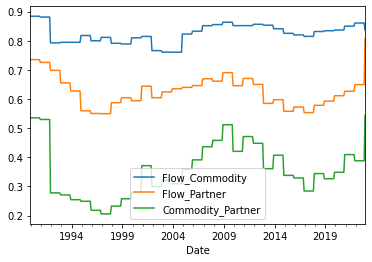

In [25]:
### TEMP

df_herf_corr = pd.DataFrame()
df_herf_corr['Flow_Commodity'] = df_herfindahl.groupby('Date').corr().loc[(All, 'By_Flow'), 'By_Commodity'].droplevel(-1)
df_herf_corr['Flow_Partner'] = df_herfindahl.groupby('Date').corr().loc[(All, 'By_Flow'), 'By_Partner'].droplevel(-1)
df_herf_corr['Commodity_Partner'] = df_herfindahl.groupby('Date').corr().loc[(All, 'By_Commodity'), 'By_Partner'].droplevel(-1)
df_herf_corr.plot()

In [29]:
### CALCULATION OF FULL HERFINDAHL INDEX FOR COMMODITY

gc.collect()
### Defining Herfindahl index calculation:
def get_herfindahl(ser_group):
    if (ser_group.count() > 0):
        ser_norm = ser_group / ser_group.sum()
        flo_herfindahl = 1 / ((ser_norm ** 2).sum() ** (1 / 2))
    else:
        flo_herfindahl = np.NaN
    return flo_herfindahl

ser_herfindahl_for_comm = ser_country_comm_flow.groupby(['Date', 'Commodity_ID']).apply(get_herfindahl)
ser_herfindahl_for_comm.name = 'Herfindahl_Commodity'

In [44]:
### WEIGHTING HERFINDAHL FOR COMMODITIES WITH TRADE FLOWS

df_herfindahl_for_comm = ser_country_comm_flow.loc[:, ser_ison_status.index].reorder_levels(['Date', 'Commodity_ID', 'Reporter']).sort_index().to_frame()\
                                              .join(ser_herfindahl_for_comm)
ser_herfindahl_factor = df_herfindahl_for_comm.reorder_levels(['Date', 'Reporter', 'Commodity_ID']).sort_index().groupby(['Date', 'Reporter'])\
                                              .apply(lambda df_group: weighted_average(df_group['Herfindahl_Commodity'], df_group['Export'] / 1000))

In [11]:
### TEMP

ser_herfindahl_factor = pd.read_hdf(str_path_herfindahl_for_comm_exp, str_key_comtrade_factor).unstack('Reporter')\
                          .reindex(pd.date_range(date_start, date_end, freq = 'BY')).stack('Reporter')
ser_herfindahl_factor.loc['2020-12-31'].sort_values()

#df_herfindahl_for_comm.loc[('2020-12-31', All, ['CN', 'QA']), :].reorder_levels(['Date', 'Reporter', 'Commodity_ID']).sort_index()
#ser_herfindahl_factor['2021-12-31'].sort_values()
#ser_herfindahl_for_comm['2021-12-31'][: 50]
#ser_country_comm_flow.loc['2021-12-31', :, '27'].sort_values()

            Reporter
2020-12-31  BD          2.922415
            PK          3.101009
            MT          3.223575
            CN          3.268710
            VN          3.343308
                          ...   
            KW          4.433612
            EC          4.441174
            NG          4.464997
            QA          4.472160
            ZM          4.707044
Length: 85, dtype: float64

In [62]:
### FOR COMMODITY HERFINDAHL FACTOR RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(df_group):
    df_result = df_group.droplevel(['Reporter']).reindex(pd.date_range(df_group.index[0][0], str_date_end, freq = 'BY'))
    df_result = df_result.resample('BM').ffill()
    return df_result
ser_herfindahl_monthly = ser_herfindahl_factor.groupby('Reporter').apply(reindex_monthly).swaplevel()
ser_herfindahl_monthly.index.names = ['Date', 'Reporter']
ser_herfindahl_monthly.name = 'Herfindahl_For_Commodity'

In [63]:
### FACTOR SAVING

ser_herfindahl_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
ser_herfindahl_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
ser_herfindahl_monthly.to_hdf(str_path_herfindahl_for_comm_exp, str_key_comtrade_factor)

In [28]:
### CALCULATION OF BY REPORTER HERFINDAHL INDEX

gc.collect()
### Defining Herfindahl index calculation:
def get_herfindahl(ser_group):
    if (ser_group.count() > 0):
        ser_norm = ser_group / ser_group.sum()
        flo_herfindahl = 1 / ((ser_norm ** 2).sum() ** (1 / 2))
    else:
        flo_herfindahl = np.NaN
    return flo_herfindahl

ser_herfindahl_partner = ser_country_partner_flow.loc[:, :, ser_ison_status.index].groupby(['Date', 'Partner']).apply(get_herfindahl)
ser_herfindahl_partner.replace({np.inf: np.NaN}, inplace = True)
ser_herfindahl_partner.name = 'Herfindahl_Reporter'

In [33]:
### BY PARTNER HERFINDAHL FACTOR RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(df_group):
    df_result = df_group.droplevel(['Partner']).reindex(pd.date_range(df_group.index[0][0], str_date_end, freq = 'BY'))
    df_result = df_result.resample('BM').ffill()
    return df_result
ser_herfindahl_monthly = ser_herfindahl_partner.groupby('Partner').apply(reindex_monthly).swaplevel()
ser_herfindahl_monthly.index.names = ['Date', 'Partner']
ser_herfindahl_monthly.name = 'Herfindahl_Partner'

In [34]:
### FACTOR SAVING

ser_herfindahl_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
ser_herfindahl_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
ser_herfindahl_monthly.to_hdf(str_path_herfindahl_partner_imp, str_key_comtrade_factor)

In [32]:
### TEMP

ser_herfindahl_partner.loc['2020-12-31', :].sort_values()

Date        Partner
2020-12-31  CA         1.528612
            MX         1.567179
            NA         1.664411
            BW         1.681133
            HK         2.079985
                         ...   
            BG         4.417565
            GR         4.446262
            LB         4.568719
            DE         4.589791
            TR         4.649067
Name: Herfindahl_Reporter, Length: 85, dtype: float64